# SOSE Heat and Salt Budgets

Evaluating the conservation of heat and salt content in the Southern Ocean State Estimate 

Author: [Ryan Abernathey](http://github.com/rabernat)

![SOSE Logo](http://sose.ucsd.edu/images/SOSEpic.png)

## Connect to Dask Cluster

Below we create a dask cluster with 30 nodes to do our work for us.

In [1]:
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=50)
cluster

** ☝️ don't forget to follow along on the dashboard **

In [2]:
client = Client(cluster)
client

<Client: scheduler='tcp://10.23.98.244:41724' processes=0 cores=0>

Import necessary Python packages

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

## Open SOSE Dataset from Cloud Storage

In [4]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/SOSE'))
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 0.5833334 0.75 ...
  * XG        (XG) float32 5.551115e-17 0.16666667 0.33333334 0.5 0.6666667 ...
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 -77.37497 -77.2083 ...
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 -77.4583 -77.29163 ...
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 -114.0 ...
    drC       (Zp1) float32 da

In [5]:
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size: 1408.75 GB


A trick for optimization: split the dataset into coordinates and data variables, and then drop the coordinates from the data variables.
This makes it easier to align the data variables in arithmetic operations.

In [6]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 0.5833334 0.75 ...
  * XG        (XG) float32 5.551115e-17 0.16666667 0.33333334 0.5 0.6666667 ...
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 -77.37497 -77.2083 ...
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 -77.4583 -77.29163 ...
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 -114.0 ...
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 2005-01-16 ...
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array

In [7]:
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 -114.0 ...
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 -77.37497 -77.2083 ...
  * XC       (XC) float32 0.083333336 0.25 0.4166667 0.5833334 0.75 ...
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 -77.4583 -77.29163 ...
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 2005-01-16 ...
  * XG       (XG) float32 5.551115e-17 0.16666667 0.33333334 0.5 0.6666667 ...
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
Data variables:
    dxC      (YC, XG) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    dyC      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    d

## Visualize Some Data

As a sanity check, let's look at some values.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
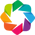

In [8]:
import holoviews as hv
from holoviews.operation.datashader import regrid
hv.extension('bokeh')

In [9]:
%%opts Image [width=900, height=400 colorbar=True] (cmap='Magma')

hv_image = hv.Dataset(ds.THETA.where(ds.hFacC>0).rename('THETA')).to(hv.Image, kdims=['XC', 'YC'], dynamic=True)
with dask.config.set(scheduler='single-threaded'):
    display(regrid(hv_image, precompute=True))

:DynamicMap   [Z,time]
   :Image   [XC,YC]   (THETA)

## Create xgcm grid

[Xgcm](http://xgcm.readthedocs.io) is a package which helps with the analysis of GCM data.

In [10]:
import xgcm
grid = xgcm.Grid(ds, periodic=('X', 'Y'))
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   YC (320) --> left
  * left     YG (320) --> center
X Axis (periodic):
  * center   XC (2160) --> left
  * left     XG (2160) --> center
T Axis (not periodic):
  * center   time (438)
Z Axis (not periodic):
  * center   Z (42) --> left
  * left     Zl (42) --> center
  * outer    Zp1 (43) --> center
  * right    Zu (42) --> center

## Tracer Budgets

Here we will do the heat and salt budgets for SOSE. In integral form, these budgets can be written as

$$
\mathcal{V} \frac{\partial S}{\partial t} = G^S_{adv} + G^S_{diff} + G^S_{surf} + G^S_{linfs}
$$


$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

In [11]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where 
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(dsr['ADVx_' + suffix], 'X') +
                          grid.diff(dsr['ADVy_' + suffix], 'Y')).rename('conv_horiz_adv_flux_' + suffix)
    conv_horiz_diff_flux = -(grid.diff(dsr['DFxE_' + suffix], 'X') +
                          grid.diff(dsr['DFyE_' + suffix], 'Y')).rename('conv_horiz_diff_flux_' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(dsr['ADVr_' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(dsr['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['DFrI_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['KPPg_' + suffix], 'Z', boundary='fill')).rename('conv_vert_diff_flux_' + suffix)
    
    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)
    
    return xr.merge(all_fluxes + [conv_all_fluxes])

In [12]:
budget_slt = tracer_flux_budget('SLT')
budget_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                      (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * Z                         (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * YC                        (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                        (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT       (time, Z, YC, XC) float32 dask.array<shape=(438

In [13]:
budget_th = tracer_flux_budget('TH')
budget_th

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * Z                        (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * YC                       (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                       (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH       (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320,

### Surface Fluxes

The surface fluxes are only active in the top model layer. We need to specify some constants to convert to the proper units and scale factors to convert to integral form. They also require some xarray special sauce to merge with the 3D variables.

In [14]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3

# treat the shortwave flux separately from the rest of the surface flux
surf_flux_th = (dsr.TFLUX - dsr.oceQsw) * coords.rA / (heat_capacity_cp * runit2mass)
surf_flux_th_sw = dsr.oceQsw * coords.rA / (heat_capacity_cp * runit2mass)

# salt
surf_flux_slt = dsr.SFLUX * coords.rA  / runit2mass
lin_fs_correction_th = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA)
lin_fs_correction_slt = -(dsr.WSLTMASS.isel(Zl=0, drop=True) * coords.rA)

# in order to align the surface fluxes with the rest of the 3D budget terms,
# we need to give them a z coordinate. We can do that with this function
def surface_to_3d(da):
    da.coords['Z'] = dsr.Z[0]
    return da.expand_dims(dim='Z', axis=1)

### Shortwave Flux

Special treatment is needed for the shortwave flux, which penetrates into the interior of the water column

In [15]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(Zl=slice(0, -200))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(dsr.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [16]:
# now we can add the to the budget datasets and they will align correctly
# into the top cell (lazily filling with NaN's elsewhere)
budget_slt['surface_flux_conv_SLT'] = surface_to_3d(surf_flux_slt)
budget_slt['lin_fs_correction_SLT'] = surface_to_3d(lin_fs_correction_slt)
budget_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                         (Z) float64 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * time                      (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * YC                        (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                        (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT       (time, Z, YC, XC) float32 dask.array<shape=(438

In [17]:
budget_th['surface_flux_conv_TH'] = surface_to_3d(surf_flux_th)
budget_th['lin_fs_correction_TH'] = surface_to_3d(lin_fs_correction_th)
budget_th['sw_flux_conv_TH'] = -grid.diff(swdown, 'Z', boundary='fill').fillna(0.)
budget_th

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                        (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * time                     (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * YC                       (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                       (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH       (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320,

### Add it all up

The total tendency should be given by

In [18]:
budget_th['total_tendency_TH'] = (budget_th.conv_total_flux_TH + 
                                  budget_th.surface_flux_conv_TH.fillna(0.) +
                                  budget_th.lin_fs_correction_TH.fillna(0.) + 
                                  budget_th.sw_flux_conv_TH)
budget_th

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                        (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * time                     (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * YC                       (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                       (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH       (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320,

In [19]:
budget_slt['total_tendency_SLT'] = (budget_slt.conv_total_flux_SLT + 
                                    budget_slt.surface_flux_conv_SLT.fillna(0.) +
                                    budget_slt.lin_fs_correction_SLT.fillna(0.))
budget_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                         (Z) float64 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 ...
  * time                      (time) datetime64[ns] 2005-01-06 2005-01-11 ...
  * YC                        (YC) float32 -77.87497 -77.7083 -77.54163 ...
  * XC                        (XC) float32 0.083333336 0.25 0.4166667 ...
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT       (time, Z, YC, XC) float32 dask.array<shape=(438

### Include the "truth"

MITgcm keeps track of the true total tendence in the `TOT?TEND` variables.
We can use these as check on our budget calculation.

In [20]:
volume = (coords.drF * coords.rA * coords.hFacC)
client.scatter(volume)
day2seconds = (24*60*60)**-1

budget_th['total_tendency_TH_truth'] = dsr.TOTTTEND * volume * day2seconds
budget_slt['total_tendency_SLT_truth'] = dsr.TOTSTEND * volume * day2seconds

## Validate Budget

Now we do some checks to verify that the budget adds up.

### Vertical and Horizontal Integrals of Budget

We will take an average over the first 10 timesteps

In [21]:
time_slice = dict(time=slice(0, 10))

In [22]:
valid_range = dict(YC=slice(-90,-30))

def check_vertical(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sel(**valid_range).sum(dim=['Z', 'XC']).mean(dim='time'))
    return ds_chk

def check_horizontal(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sel(**valid_range).sum(dim=['YC', 'XC']).mean(dim='time'))
    return ds_chk

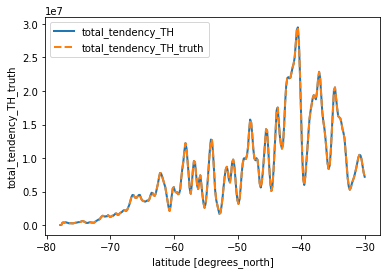

In [23]:
th_vert = check_vertical(budget_th.isel(**time_slice), 'TH').load()
th_vert.total_tendency_TH.plot(linewidth=2)
th_vert.total_tendency_TH_truth.plot(linestyle='--', linewidth=2)
plt.legend()

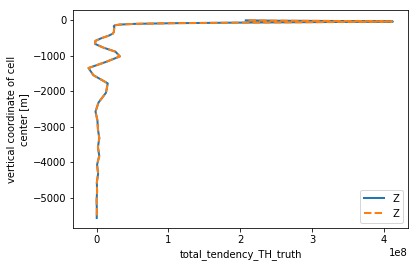

In [23]:
th_horiz = check_horizontal(budget_th.isel(**time_slice), 'TH').load()
th_horiz.total_tendency_TH.plot(linewidth=2, y='Z')
th_horiz.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, y='Z')
plt.legend()

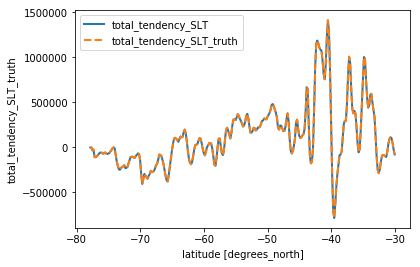

In [24]:
slt_vert = check_vertical(budget_slt.isel(**time_slice), 'SLT').load()
slt_vert.total_tendency_SLT.plot(linewidth=2)
slt_vert.total_tendency_SLT_truth.plot(linestyle='--', linewidth=2)
plt.legend()

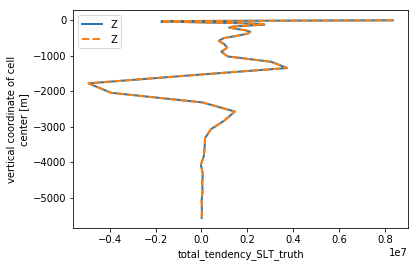

In [25]:
slt_horiz = check_horizontal(budget_slt.isel(**time_slice), 'SLT').load()
slt_horiz.total_tendency_SLT.plot(linewidth=2, y='Z')
slt_horiz.total_tendency_SLT_truth.plot(linestyle='--', linewidth=2, y='Z')
plt.legend()

### Histogram Analysis of Error

The curves look the same. But how do we know whether our error is truly "small"?
Answer: we compare the distribution of the error

$$ P( G_{est} - G_{truth} ) $$

to the distribution of the other terms in the equation, e.g. $P(G_{adv})$.

First we try to determine the appropriate range for our histograms by looking at the maximum values.

In [26]:
budget_th.isel(**time_slice).max().load()

<xarray.Dataset>
Dimensions:                  ()
Data variables:
    conv_horiz_adv_flux_TH   float32 19145940.0
    conv_horiz_diff_flux_TH  float32 89941.086
    conv_vert_adv_flux_TH    float32 23173650.0
    conv_vert_diff_flux_TH   float32 534407.7
    conv_total_flux_TH       float32 510076.62
    surface_flux_conv_TH     float32 21228.941
    lin_fs_correction_TH     float32 10248.496
    sw_flux_conv_TH          float32 21346.447
    total_tendency_TH        float32 510076.62
    total_tendency_TH_truth  float32 297048.4

In [27]:
budget_slt.isel(**time_slice).max().load()

<xarray.Dataset>
Dimensions:                   ()
Data variables:
    conv_horiz_adv_flux_SLT   float32 94174560.0
    conv_horiz_diff_flux_SLT  float32 17939.193
    conv_vert_adv_flux_SLT    float32 105942130.0
    conv_vert_diff_flux_SLT   float32 76532.33
    conv_total_flux_SLT       float32 5261500.5
    surface_flux_conv_SLT     float32 7828.6157
    lin_fs_correction_SLT     float32 20308.545
    total_tendency_SLT        float32 5261500.5
    total_tendency_SLT_truth  float32 46110.24

In [28]:
# parameters for histogram calculation
th_range = (-2e7, 2e7)
slt_range = (-1e8, 1e8)
valid_region = dict(YC=slice(-90, -30))
nbins = 301

In [29]:
# budget errors
error_th = budget_th.total_tendency_TH - budget_th.total_tendency_TH_truth
error_slt = budget_slt.total_tendency_SLT - budget_slt.total_tendency_SLT_truth

In [30]:
# calculate theta error histograms over the whole time range
adv_hist_th, hbins_th = dsa.histogram(budget_th.conv_horiz_adv_flux_TH.sel(**valid_region).data,
                                        bins=nbins, range=th_range)
err_hist_th, hbins_th = dsa.histogram(error_th.sel(**valid_region).data,
                                        bins=nbins, range=th_range)
err_hist_th, adv_hist_th = dask.compute(err_hist_th, adv_hist_th)

Text(0.5,1,'THETA Budget')

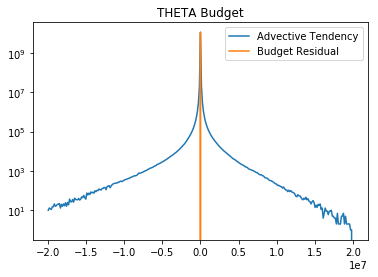

In [35]:
bin_c_th = 0.5*(hbins_th[:-1] + hbins_th[1:])
plt.semilogy(bin_c_th, adv_hist_th, label='Advective Tendency')
plt.semilogy(bin_c_th, err_hist_th, label='Budget Residual')
plt.legend()
plt.title('THETA Budget')

In [32]:
# calculate salt error histograms over the whole time range
adv_hist_slt, hbins_slt = dsa.histogram(budget_slt.conv_horiz_adv_flux_SLT.sel(**valid_region).data,
                                        bins=nbins, range=slt_range)
err_hist_slt, hbins_slt = dsa.histogram(error_slt.sel(**valid_region).fillna(-9e13).data,
                                        bins=nbins, range=slt_range)
err_hist_slt, adv_hist_slt = dask.compute(err_hist_slt, adv_hist_slt)

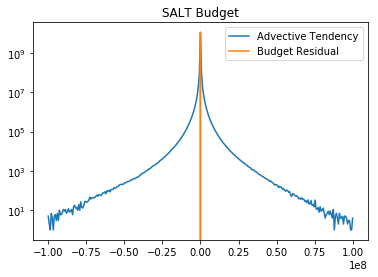

In [36]:
bin_c_slt = 0.5*(hbins_slt[:-1] + hbins_slt[1:])
plt.semilogy(bin_c_slt, adv_hist_slt, label='Advective Tendency')
plt.semilogy(bin_c_slt, err_hist_slt, label='Budget Residual')
plt.title('SALT Budget')
plt.legend()

These figures show that the error is extremely small compared to the other terms in the budget.

## Weddell Sea Budget Timeseries

Finally, we can do some science: compute the salinity budget for a specific region, such as the upper Weddell Sea.

In [40]:
budget_slt_weddell = (budget_slt
                        .sel(YC=slice(-80, -68), XC=slice(290, 360), Z=slice(0, -500))
                        .sum(dim=('XC', 'YC', 'Z'))
                        .load())
budget_slt_weddell

<xarray.Dataset>
Dimensions:                   (time: 438)
Coordinates:
  * time                      (time) datetime64[ns] 2005-01-06 2005-01-11 ...
Data variables:
    conv_horiz_adv_flux_SLT   (time) float32 -43632460.0 -36267436.0 ...
    conv_horiz_diff_flux_SLT  (time) float32 4892.9424 6978.3486 10441.184 ...
    conv_vert_adv_flux_SLT    (time) float32 -110508056.0 56280100.0 ...
    conv_vert_diff_flux_SLT   (time) float32 4837898.5 -1010.3694 -1765.5066 ...
    conv_total_flux_SLT       (time) float32 -149297810.0 20018620.0 ...
    surface_flux_conv_SLT     (time) float32 -8284682.0 -3737431.2 ...
    lin_fs_correction_SLT     (time) float32 149588460.0 -17810290.0 ...
    total_tendency_SLT        (time) float32 -7993949.5 -1529094.9 ...
    total_tendency_SLT_truth  (time) float32 -7993943.5 -1529095.6 ...

Text(0.5,1,'Weddell Sea Salt Budget')

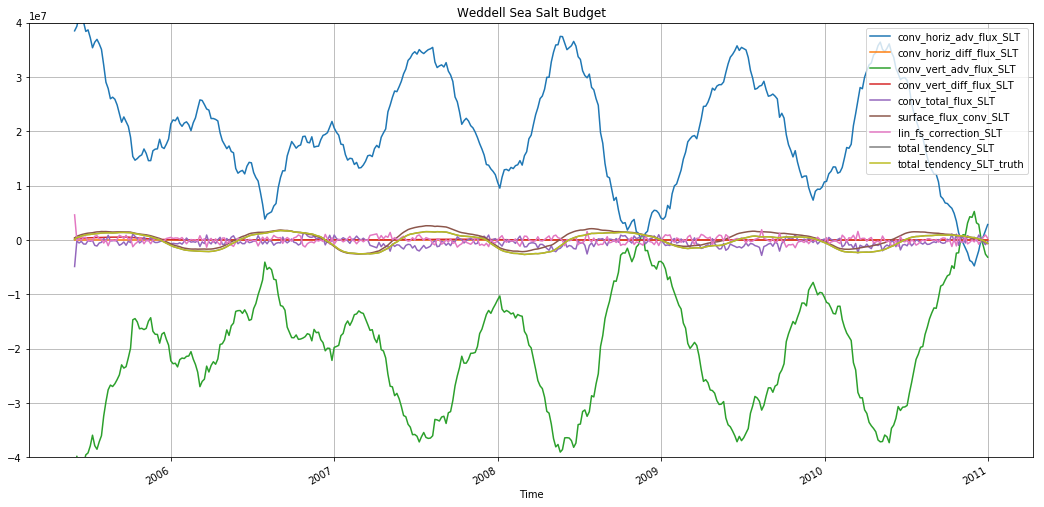

In [54]:
plt.figure(figsize=(18,8))
for v in budget_slt_weddell.data_vars:
    budget_slt_weddell[v].rolling(time=30).mean().plot(label=v)
plt.ylim([-4e7, 4e7])
plt.legend()
plt.grid()
plt.title('Weddell Sea Salt Budget')

Text(0.5,1,'Weddell Sea Salt Budget')

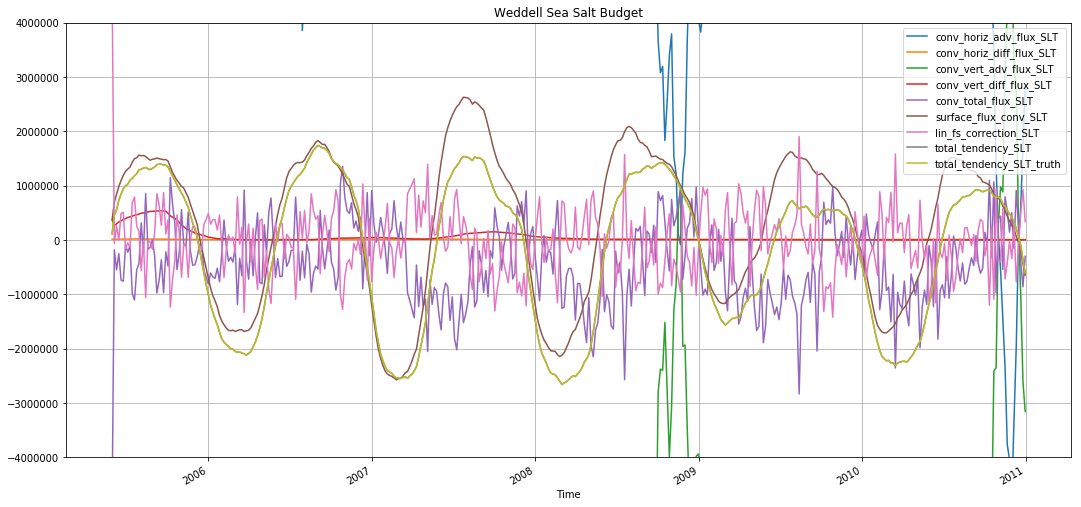

In [55]:
plt.figure(figsize=(18,8))
for v in budget_slt_weddell.data_vars:
    budget_slt_weddell[v].rolling(time=30).mean().plot(label=v)
plt.ylim([-4e6, 4e6])
plt.legend()
plt.grid()
plt.title('Weddell Sea Salt Budget')

These figures show that, while they advective terms are the largest ones in the budget, the actual variability in salinity is driven primarily by the surface fluxes.

### Removing Climatlogy

The timeseries is pretty short, but nevertheless we can try to remove the climatology to get a better idea of what drives the interannual variability

In [57]:
budget_slt_weddell_mm = budget_slt_weddell.groupby('time.month').mean(dim='time')
budget_slt_weddell_anom = budget_slt_weddell.groupby('time.month') - budget_slt_weddell_mm

Text(0.5,1,'Weddell Sea Anomaly Salt Budget')

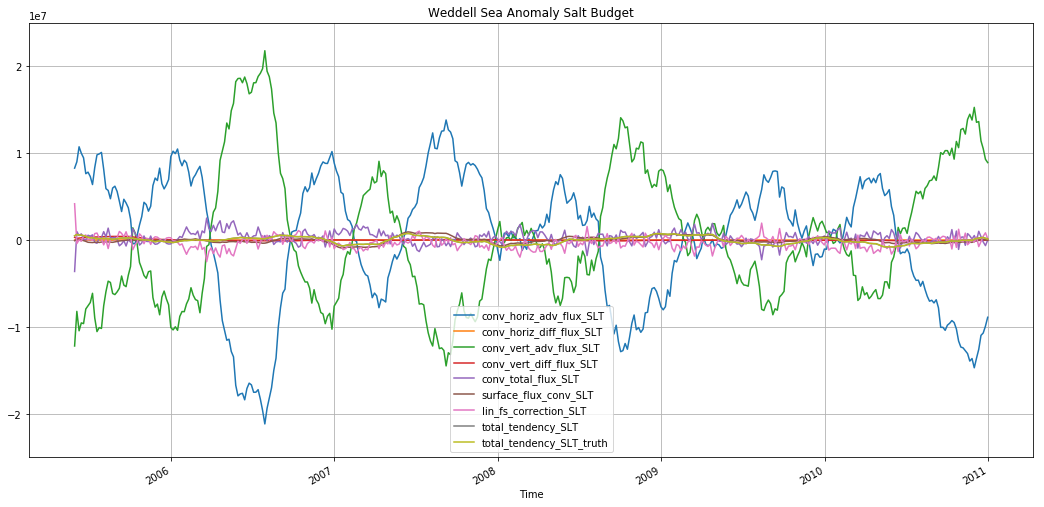

In [60]:
plt.figure(figsize=(18,8))
for v in budget_slt_weddell.data_vars:
    budget_slt_weddell_anom[v].rolling(time=30).mean().plot(label=v)
plt.ylim([-2.5e7, 2.5e7])
plt.legend()
plt.grid()
plt.title('Weddell Sea Anomaly Salt Budget')

Text(0.5,1,'Weddell Sea Anomaly Salt Budget')

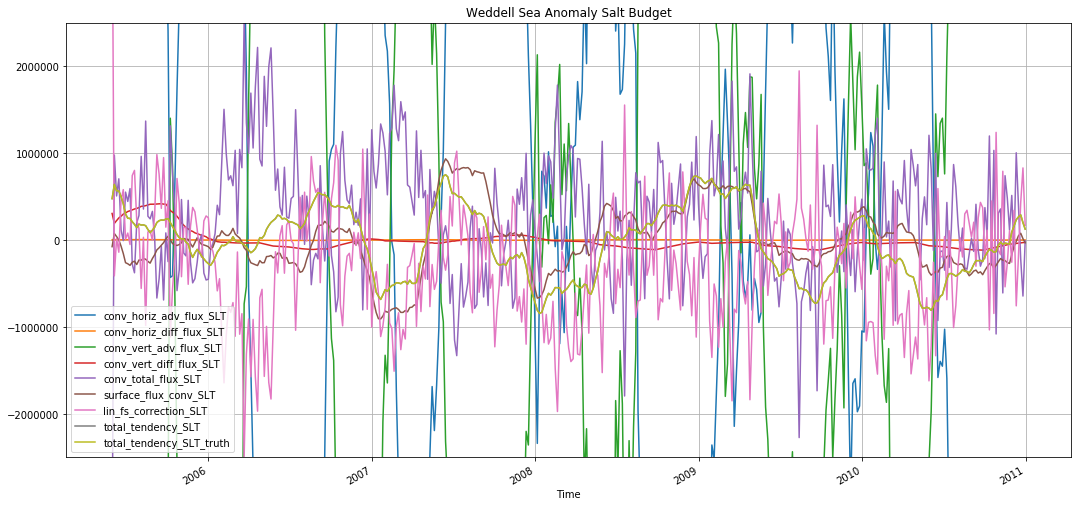

In [61]:
plt.figure(figsize=(18,8))
for v in budget_slt_weddell.data_vars:
    budget_slt_weddell_anom[v].rolling(time=30).mean().plot(label=v)
plt.ylim([-2.5e6, 2.5e6])
plt.legend()
plt.grid()
plt.title('Weddell Sea Anomaly Salt Budget')

The monthly anomaly is also premoninantly driven by surface forcing.